In [2]:
!pip install rasterio
!pip install geopandas


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 63.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 73.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 84.2 MB/s eta 0:00:00


In [3]:
import os

import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize

import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union

import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

In [21]:
import rasterio
import geopandas as gpd

# Read in the Sentinel2 image
raster_path = '/content/T36UXV_20200406T083559_TCI_10m.jp2'
with rasterio.open(raster_path, "r", driver="JP2OpenJPEG") as src:
    raster_img = src.read()
    raster_meta = src.meta

In [14]:
src.meta

{'driver': 'JP2OpenJPEG',
 'dtype': 'uint8',
 'nodata': None,
 'width': 10980,
 'height': 10980,
 'count': 3,
 'crs': CRS.from_epsg(32636),
 'transform': Affine(10.0, 0.0, 600000.0,
        0.0, -10.0, 5500020.0)}

In [22]:
# Read in the mask file
mask_path = '/content/Masks_T36UXV_20190427.shp'
df_mask = gpd.read_file(mask_path)
df_mask.sample(5)

ERROR:fiona._env:Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



,id,Data,Code,Descriptio,Comments,Image,geometry
288,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((35.67373 49.50901, 35.67396 49.50887..."
927,NaN,NaN,2.0,branch of tree,NaN,T36UXV_20190427T083601,"POLYGON ((36.14892 49.51930, 36.14952 49.51922..."
861,NaN,NaN,1.0,color+ structure,NaN,T36UXV_20190427T083601,"POLYGON ((34.22277 49.22534, 34.22325 49.22464..."
211,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((36.15959 49.57393, 36.15815 49.57417..."
406,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((34.77999 49.41242, 34.78296 49.41069..."


In [23]:
df_mask.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 936 entries, 0 to 935
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id          0 non-null      float64 
 1   Data        0 non-null      float64 
 2   Code        340 non-null    float64 
 3   Descriptio  335 non-null    object  
 4   Comments    17 non-null     object  
 5   Image       325 non-null    object  
 6   geometry    935 non-null    geometry
dtypes: float64(3), geometry(1), object(3)
memory usage: 51.3+ KB


In [24]:
df_mask.shape

(936, 7)

In [25]:
print(df_mask.isnull().sum())

id            936
Data          936
Code          596
Descriptio    601
Comments      919
Image         611
geometry        1
dtype: int64


In [26]:
df_mask = df_mask[df_mask.geometry.notnull()]

In [27]:
df_mask.shape

(935, 7)

In [28]:
print(raster_img.shape)

(3, 10980, 10980)


In [29]:
raster_img = reshape_as_image(raster_img)

In [30]:
print(raster_img.shape)

(10980, 10980, 3)


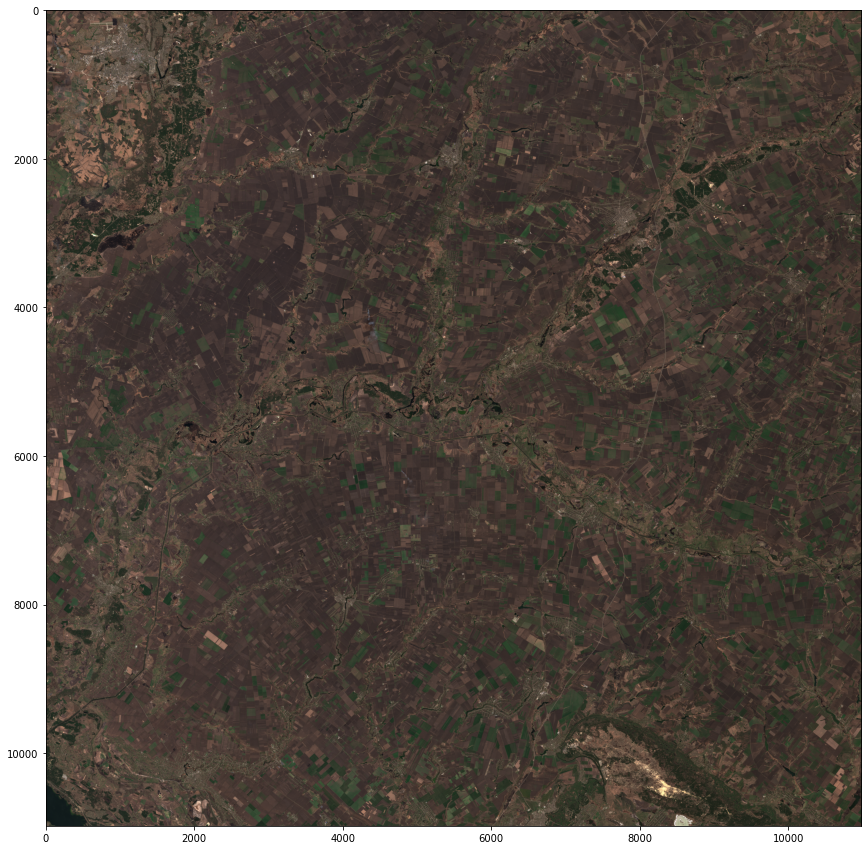

In [21]:
plt.figure(figsize=(15,15))
plt.imshow(raster_img);

In [31]:
#Checking coordinates of polygon using Polygon methods
df_mask['geometry'][0].exterior.coords.xy

(array('d', [35.62916346617293, 35.63014960535702, 35.631175190108465, 35.631214635675825, 35.630031268654925, 35.62888734720139, 35.62813788142149, 35.62774342574785, 35.62813788142149, 35.62916346617293]),
 array('d', [49.602931546762534, 49.60162984303954, 49.60080148612491, 49.59981534694083, 49.6001703570471, 49.60111705066382, 49.60214263541526, 49.60289210119517, 49.60312877459935, 49.602931546762534]))

In [19]:
# cut fields from Raster

src = rasterio.open(raster_path, 'r')
failed = []
for num, row in df_mask.iterrows():
    try:
        masked_image, out_transform = rasterio.mask.mask(src, [mapping(row['geometry'])], crop=True, nodata=0)
    except:
        failed.append(num)
print("Rasterio failed to mask {} files".format(len(failed)))

Rasterio failed to mask 935 files


In [34]:
# Converting GeoDataframe to raster CRS

# assigning crs
df_mask.crs = {'init' :'epsg:4324'}

#transforming polygons to the raster crs
df_mask = df_mask.to_crs({'init' : raster_meta['crs']['init']})

/usr/local/lib/python3.9/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [25]:
#out_image, out_transform = rasterio.mask.mask(src, mask.geometry, crop=True)
#raster_img = out_image.astype(np.float32)

TypeError: ignored

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(raster_img, df_mask, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Create the CNN model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=X_train[0].shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('Test accuracy:', test_acc)


Here are some proposals that could potentially help to improve the effectiveness of soil erosion detection models:

Including temporal information: Soil erosion is a dynamic process that can vary over time. Including temporal information such as historical erosion data, time-series satellite imagery, and weather data can help to capture the temporal changes and improve the accuracy of the model.

Incorporating multi-source data: Soil erosion is a complex phenomenon and can be influenced by various factors. Incorporating data from different sources such as remote sensing, weather stations, and soil moisture sensors can improve the accuracy of the model

As for Python:

Tuning hyperparameters: Hyperparameters such as learning rate, batch size, and number of epochs can significantly affect the model's performance. Using techniques such as grid search or random search to find the optimal hyperparameters can improve the model's accuracy. The GridSearchCV class from the sklearn.model_selection module can be used for hyperparameter tuning.

Using a different loss function: The binary cross-entropy loss function is commonly used for binary classification problems such as soil erosion detection. However, using a different loss function such as focal loss can improve the model's performance. These loss functions are available in the tensorflow_addons package.
